# Imports

In [43]:
import os
import sys
import shutil
import math
from typing import *
from enum import Enum
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from graph_tool.all import *

In [62]:
def preprocess_graph(_g:Graph, inplace: bool=False)->Graph:
    """
    MUST use on each network before all other analysis!
    removes duplicate edges and loops. Uses and returns a preprocessed copy of the graph.
    :param _g:
    :return: Graph
    """
    if not inplace:
        _g_cpy = _g.copy()
    else:
        _g_cpy = _g

    remove_parallel_edges(_g_cpy)
    remove_self_loops(_g_cpy)

    return _g_cpy

def get_v_properties_names(_g: Graph, **kwargs)->List[str]:
    props = list(_g.vp.keys())
    if kwargs.get("v_properties_to_exclude", None) is not None:
        if not isinstance(kwargs.get("v_properties_to_exclude"), List) or any([not isinstance(i, str) for i in kwargs.get("v_properties_to_exclude")]):
            raise TypeError(f"v_properties_to_exclude must be a list of only strings! but got: \n{kwargs.get('v_properties_to_exclude')}")
        for prop_to_exclude in kwargs.get("v_properties_to_exclude"):
            props.remove(prop_to_exclude)
    return props

def get_e_properties_names(_g: Graph, **kwargs)->List[str]:
    props = list(_g.ep.keys())
    if kwargs.get("e_properties_to_exclude", None) is not None:
        if not isinstance(kwargs.get("e_properties_to_exclude"), List) or any([not isinstance(i, str) for i in kwargs.get("e_properties_to_exclude")]):
            raise TypeError(f"e_properties_to_exclude must be a list of only strings! but got: \n{kwargs.get('e_properties_to_exclude')}")
        for prop_to_exclude in kwargs.get("e_properties_to_exclude"):
            props.remove(prop_to_exclude)
    return props

def get_g_properties_names(_g: Graph, **kwargs) -> Dict[str, List[str]]:
    return {
        'edge_properties': get_e_properties_names(_g=_g, **kwargs),
        'vertex_properties': get_v_properties_names(_g=_g, **kwargs)
    }

def calculate_graph_properties(_g: Graph,
                               properties_to_analyze: Dict[str, List[str]]) \
    -> Dict[str, Dict[str, float]]:
    component_to_properties_values_dict = {}
    for component, component_properties_to_analyze in properties_to_analyze.items():
        component_to_properties_values_dict[component] = {}
        component_rep = 'e' if 'edge' in component.lower() else 'v'
        # component_g_props = _g.properties[component_rep]
        for property_name in component_properties_to_analyze:
            property_values = _g.properties[(component_rep, property_name)].a
            property_mean = np.mean(property_values)
            property_std = np.std(property_values)
            component_to_properties_values_dict[component][f'{property_name}'] = {}
            component_to_properties_values_dict[component][f'{property_name}']['mean'] = property_mean
            component_to_properties_values_dict[component][f'{property_name}']['std'] = property_std
    return component_to_properties_values_dict

def extract_graph_attributes_distributions(_g: Graph, edge_properties_to_extract: Union[None, List[str]]):
    pass

# Experimentation

In [5]:
exp_graph_path = '/Users/yishaiazabary/PycharmProjects/University/BrainVasculatureGraphs/MiceBrainSubgraphs/subgraph_area_Striatum.gt'
g = preprocess_graph(load_graph(exp_graph_path))

In [6]:
print(f"#vertices: {g.num_vertices()}, #edges: {g.num_edges()}")

#vertices: 17603, #edges: 16507


In [20]:
properties_to_analyze = get_g_properties_names(g, v_properties_to_exclude=['coordinates', 'artery_raw', 'coordinates_atlas', 'radii_atlas', 'annotation', 'distance_to_surface'], e_properties_to_exclude= ['artery_raw', 'edge_geometry_indices', 'radii_atlas', 'distance_to_surface', 'artery'])
properties_to_analyze

{'edge_properties': ['length', 'artery_binary', 'radii', 'vein_big', 'vein'],
 'vertex_properties': ['radii', 'artery_binary']}

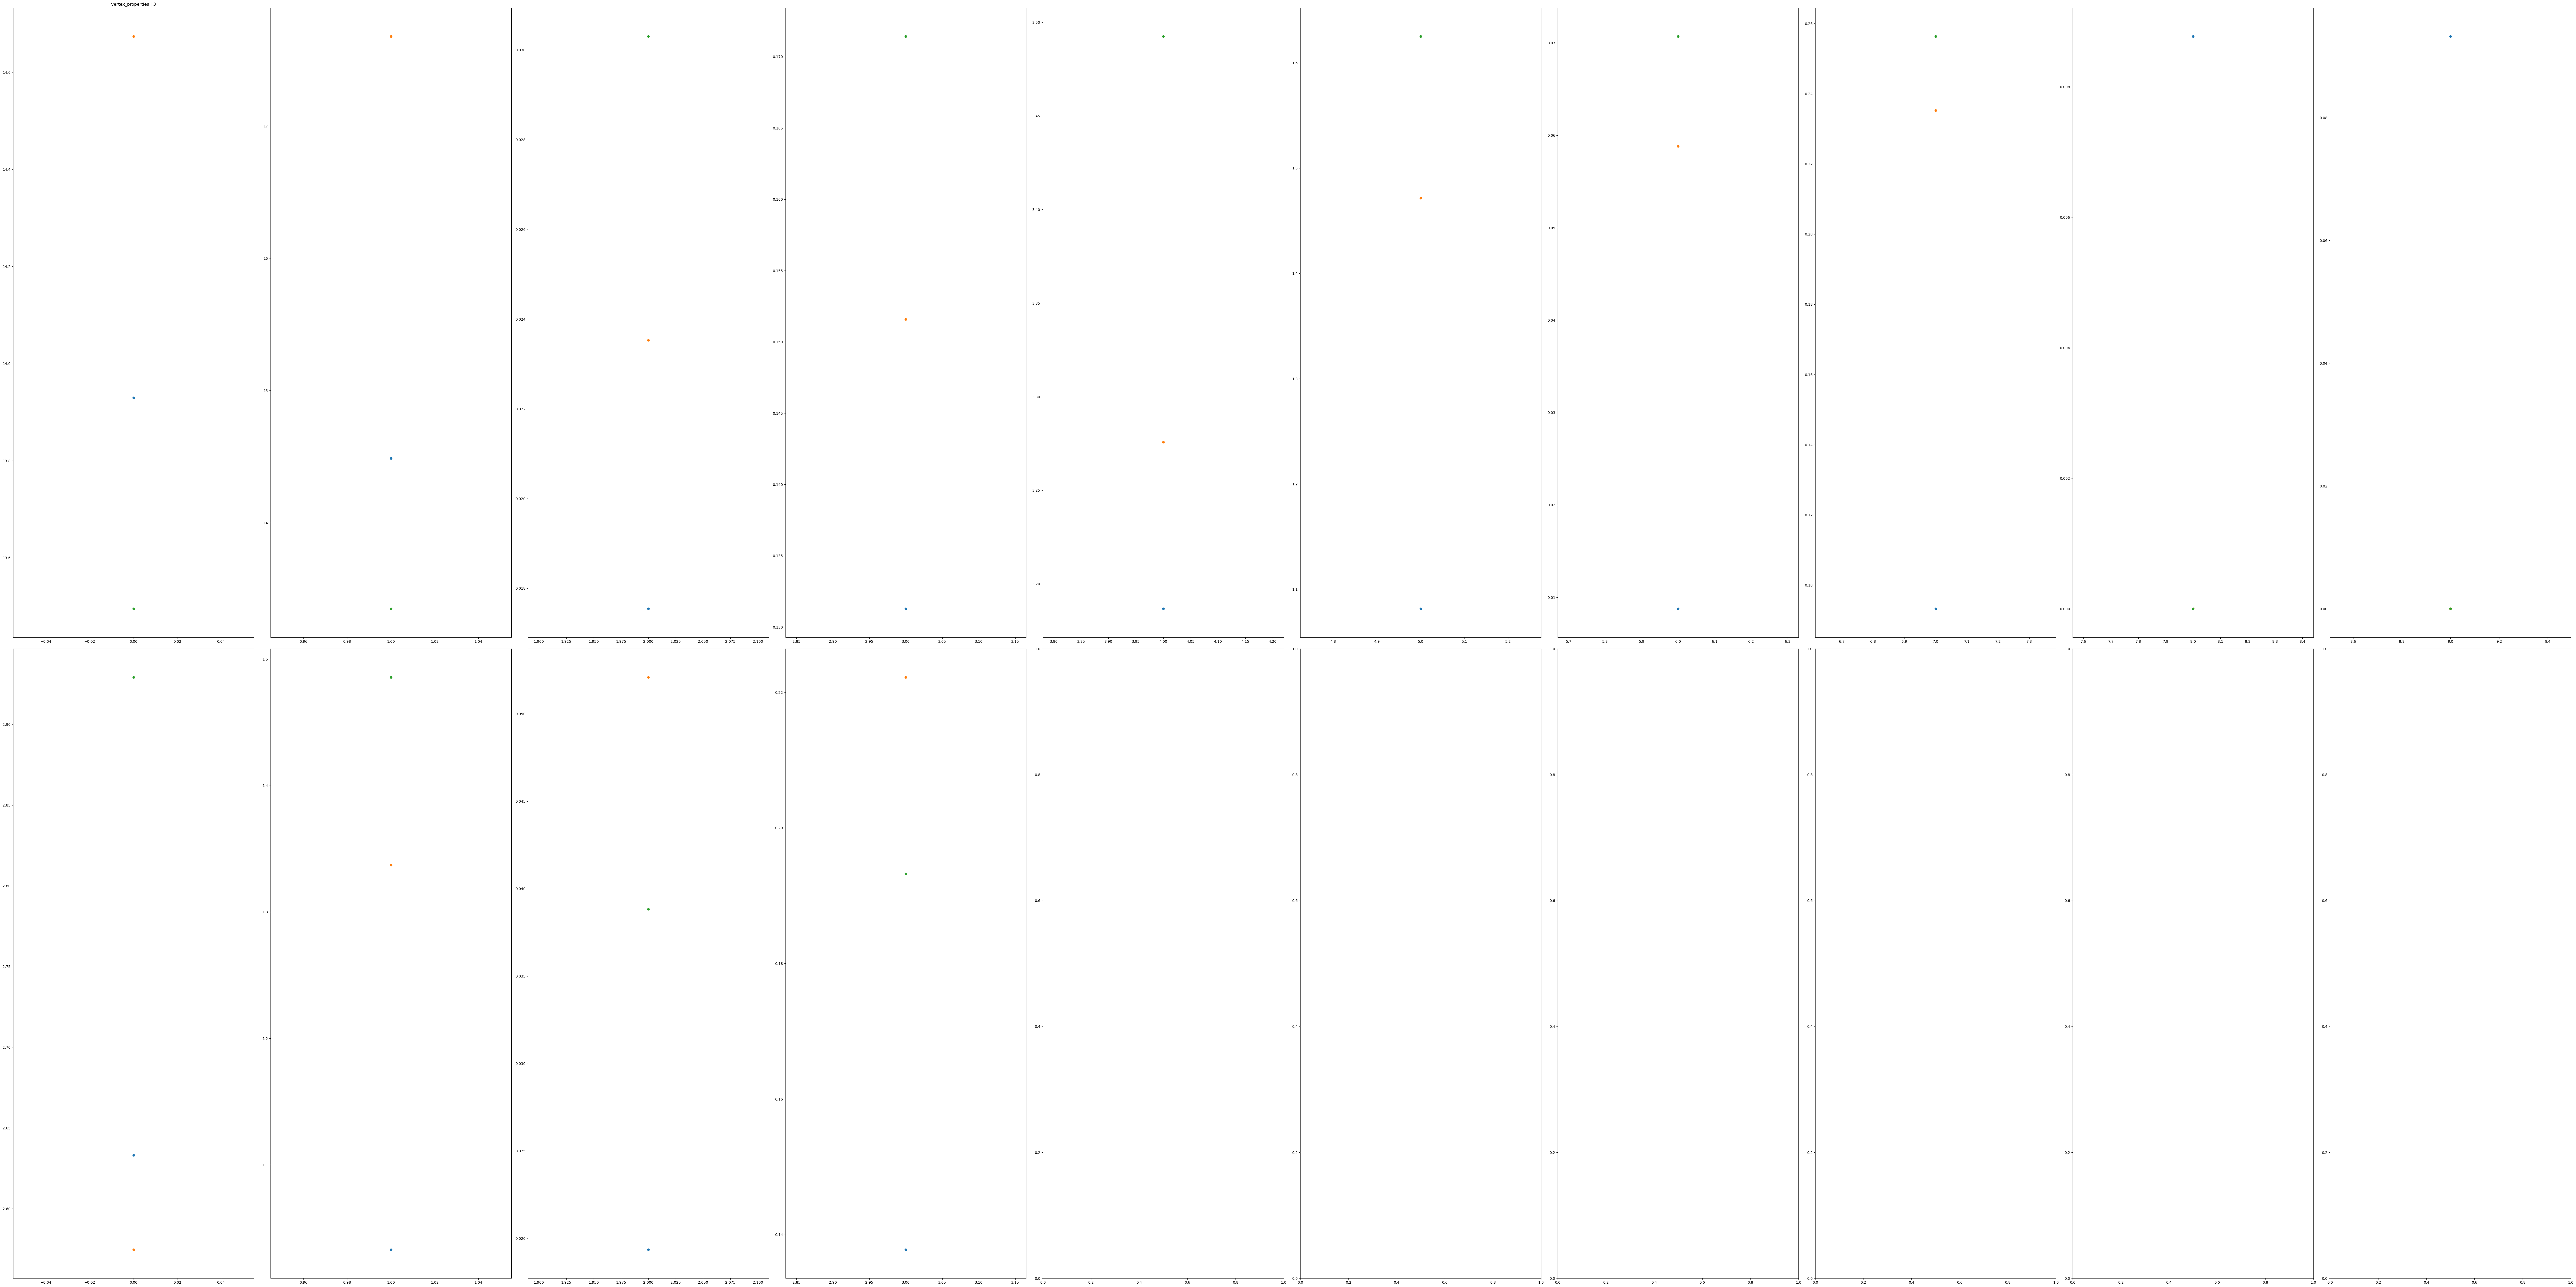

In [56]:
def plot_properties_stats_multiple_graphs(graphs_components_properties_stats_dict: Dict[str, Dict[str, Dict[str, np.array]]],
                          **kwargs) -> None:
    # components = list(components_properties_stats_dict.keys())
    n_graphs = len(graphs_components_properties_stats_dict)
    _g1_components_properties_stats_dict = list(graphs_components_properties_stats_dict.values())[0]
    n_components = len(_g1_components_properties_stats_dict)
    max_n_properties_stats = max([len(comp_properties_dict) for comp_properties_dict in list(_g1_components_properties_stats_dict.values())])
    fig, axis = plt.subplots(n_components, max_n_properties_stats, figsize=(100, 50))
    g_idx = 0 # graph index
    for graph_name, graph_stats_dict in graphs_components_properties_stats_dict.items():
        c_idx = 0 # component index
        for component, component_stat_dict in graph_stats_dict.items():
            p_idx = 0 # property index
            for prop_stat_name, prop_stat_val in component_stat_dict.items():
                axis[c_idx, p_idx].scatter([p_idx], [prop_stat_val.tolist()])
                p_idx += 1
            c_idx += 1
        g_idx += 1

    c_idx = 0 # component index
    for component, component_stat_dict in graph_stats_dict.items():
        p_idx = 0 # property index
        for prop_stat_name, prop_stat_val in enumerate(component_stat_dict.items()):
            axis[c_idx, p_idx].set_title(f"{component} | {prop_stat_name}")

    plt.tight_layout()
    plt.savefig(kwargs.get('path_to_save_fig', 'tmp_fig.png'), dpi=200)
    plt.savefig(kwargs.get('path_to_save_fig', 'tmp_fig.png').replace('.png', '.eps'), dpi=200)



plot_properties_stats_multiple_graphs(graphs_stats)


In [63]:
graphs_dir = '/Users/yishaiazabary/PycharmProjects/University/BrainVasculatureGraphs/MiceBrainSubgraphs'
graphs_names = ['subgraph_area_supramammillary decussation.gt',
                'subgraph_area_ventral tegmental decussation.gt',
                'subgraph_area_Trochlear nucleus.gt'] # list(filter(lambda x: x.endswith('.gt'), os.listdir(graphs_dir)))
graphs_stats = {g_name: calculate_graph_properties(load_graph(os.path.join(graphs_dir, g_name)), properties_to_analyze)
                for g_name in graphs_names}

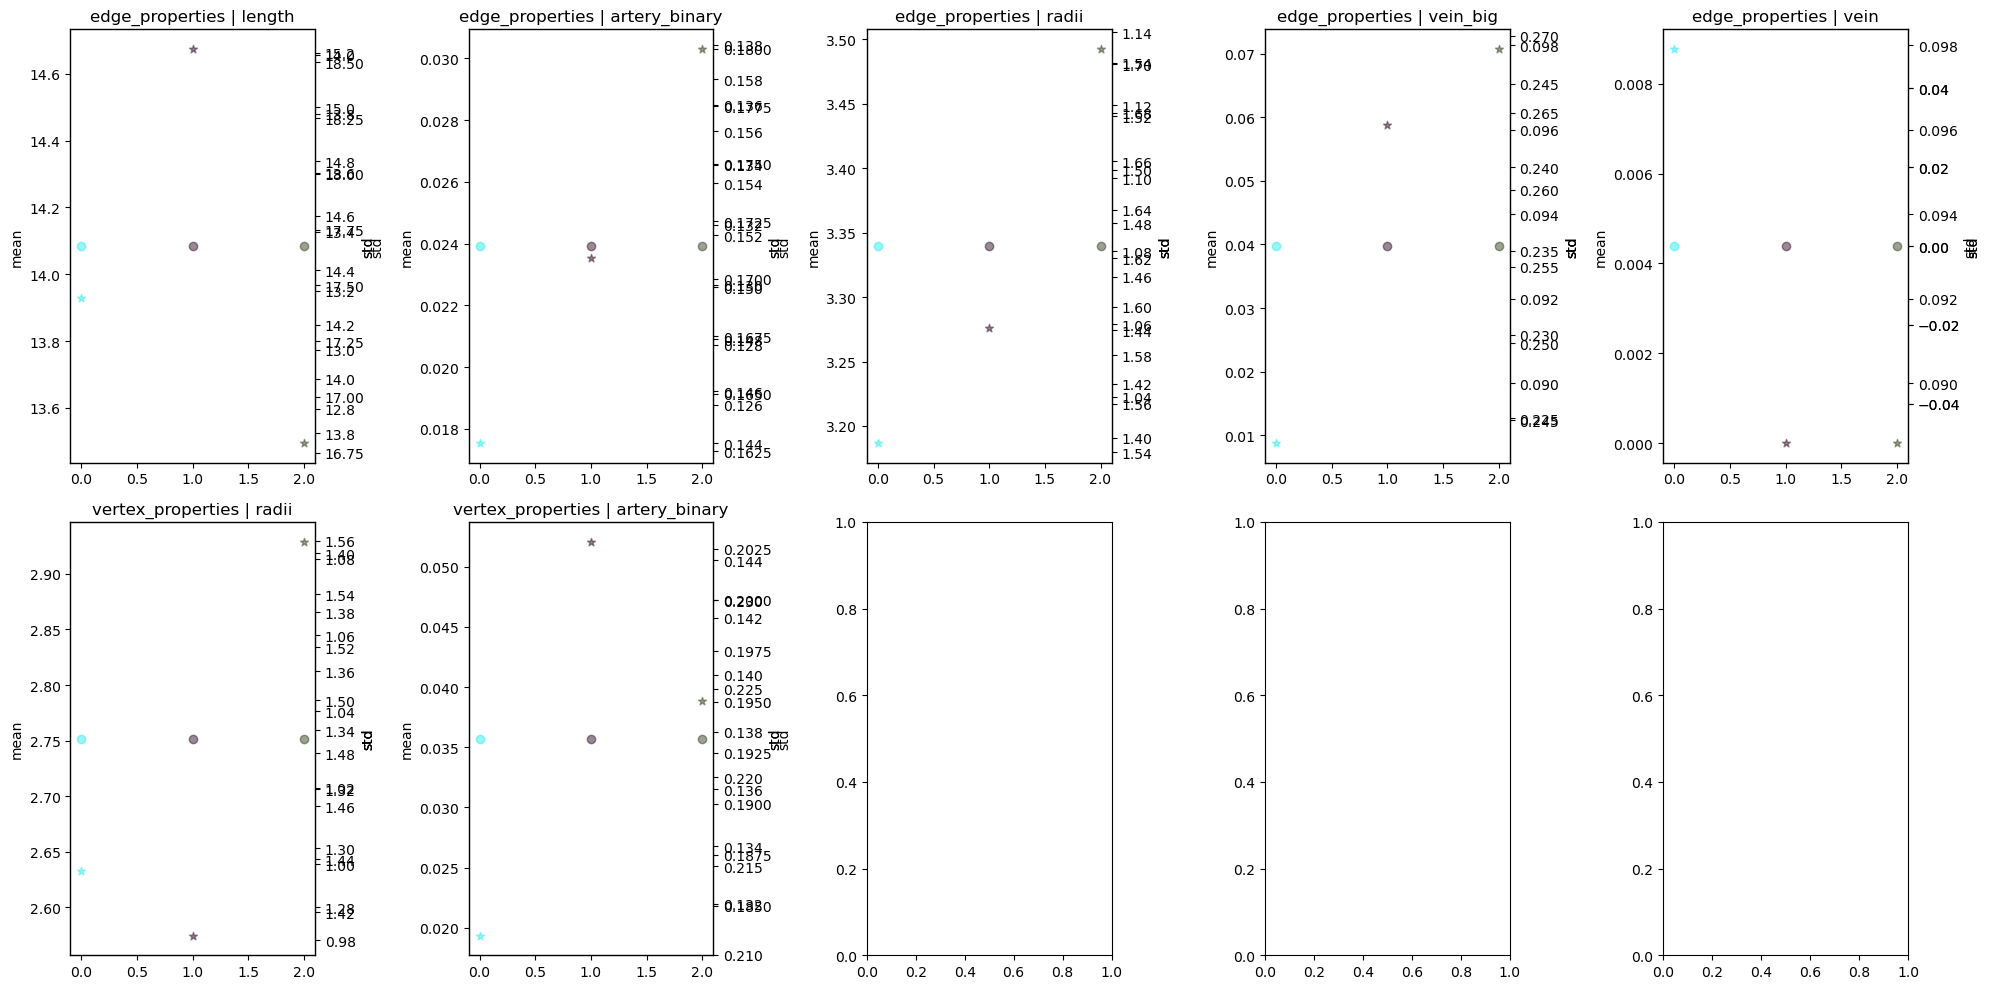

In [81]:
graphs_components_properties_stats_dict = graphs_stats
n_graphs = len(graphs_components_properties_stats_dict)
_g1_components_properties_stats_dict = list(graphs_components_properties_stats_dict.values())[0]
n_components = len(_g1_components_properties_stats_dict)
max_n_properties_stats = max([len(comp_properties_dict) for comp_properties_dict in list(_g1_components_properties_stats_dict.values())])
fig, axis = plt.subplots(n_components, max_n_properties_stats, figsize=(20, 10))
graphs_clrs = {g_idx: (np.random.random(3) / (g_idx+1)).tolist()+[.5] for g_idx in range(n_graphs)}
g_idx = 0 # graph index
for graph_name, graph_stats_dict in graphs_components_properties_stats_dict.items():
    c_idx = 0 # component index
    for component, component_stat_dict in graph_stats_dict.items():
        p_idx = 0 # property index
        for prop_name in component_stat_dict.keys():
            prop_vals = list(component_stat_dict[prop_name].values())
            prop_stat_names = list(component_stat_dict[prop_name].keys())

            axis[c_idx, p_idx].scatter([g_idx], [prop_vals[0]], c=[graphs_clrs[g_idx]], marker='*')
            axis[c_idx, p_idx].set_ylabel(prop_stat_names[0])

            t_ax_twin = axis[c_idx, p_idx].twinx()
            t_ax_twin.scatter([g_idx], [prop_vals[1]], c=[graphs_clrs[g_idx]], marker='o')
            t_ax_twin.set_ylabel(prop_stat_names[1])

            axis[c_idx, p_idx].set_title(f"{component} | {prop_name}")

            p_idx += 1
        c_idx += 1
    g_idx += 1
plt.tight_layout()
plt.show()